# Category classifier
The goal of this project is to output a classifier which will predict the review category.

**Customer/Use Case:** Potential customer could be Yelp to aid in tagging of businesses automatically using the input review text
    * Special care will have to be given to which prediction thresholds to use in order to strike a balance between precision & recall for the given use case.

**Approach:** 
1) Data curation and EDA (accomplished in sperate notebooks)
2) Data cleaning
    * Reducing feature and data scope (**Initially PA only**)
4) Featurize the review data
    * First pass will be using **tf-idf**, but additional embeddings could be used as time permits
5)  Budilding out classifiers
    * **Initial POC** will be binary -- restaurant, not-restaurant -- classifier.
    * Secondary will be **multi-class**
    * Plan is to test the following ML classifiers:
      * Logistic Regression
      * Random Forest
      * Gradient Boosted
      * Other classifiers as time permits
6) Evaluate classifers
   * See note above about threshold selection
7) Deployment
   * This is a stretch goal. Would be cool to host on AWS for online input

In [162]:
# Importing all packages including NLTK downloads as necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk.corpus
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, roc_auc_score, f1_score
first_run = False
if first_run:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
import dataprep

## Importing and cleaning data

In [2]:
data_import = True
if data_import:
    business = pd.read_csv("yelp_dataset/yelp_academic_dataset_business.csv", low_memory=False)
    reviews = pd.read_csv("yelp_dataset/yelp_academic_dataset_review.csv")

In [3]:
# The review cleaning function take a long time. Filtering dataset before we go further.
clean_business = dataprep.clean_business_data(business)
PA_business = clean_business[clean_business['state'] == 'PA']

filtered_reviews = reviews[reviews['business_id'].isin(PA_business['business_id'])].copy()
PA_reviews = dataprep.clean_review_data(filtered_reviews)

In [4]:
print(business.shape[0])
print(PA_business.shape[0])
print(reviews.shape[0])
print(PA_reviews.shape[0])

150346
34039
6990280
1596423


### Filtering for PA only

In [5]:
# Slicing out only the columns that we may need going forward
PA_business = PA_business[['business_id', 'name', 'category_split']]
PA_reviews = PA_reviews[['review_id', 'business_id', 'text']]

## Joining datasets

In [6]:
PA_data = PA_business.merge(PA_reviews, how='inner', on='business_id', validate='one_to_many')

### Creating target variable for binary classifier
i.e. Restaurant vs. Not-Restaurant

In [7]:
PA_data['is_restaurant'] = PA_data.apply(lambda row: row['category_split'].count('restaurants') > 0, 
                                         axis=1)

In [8]:
# The classes here are imbalanced, but there are so many records, that I'm not concerned right now
PA_data['is_restaurant'].value_counts()

is_restaurant
True     1098442
False     497981
Name: count, dtype: int64

## Getting embeddings from tf-idf for featurization

In [9]:
# Identifying stopwords from multiple sources
my_stopwords = ['review']
nltk_stop_words = list(nltk.corpus.stopwords.words('english'))
nltk_stop_words = [word.translate(str.maketrans('', '', string.punctuation)) for word in nltk_stop_words]
stopwords = list(set(list(ENGLISH_STOP_WORDS) + my_stopwords + nltk_stop_words))

In [10]:
# Lemmatizing words
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
        
tf = TfidfVectorizer(strip_accents='unicode',
                     tokenizer=LemmaTokenizer(),
                     stop_words=stopwords,
                     max_features=500) # Setting at 500 for POC. Could be tuned further

In [11]:
X_train, X_test , y_train, y_test = train_test_split(PA_data['text'].values,
                                                     PA_data['is_restaurant'].values, 
                                                     test_size=0.25, 
                                                     random_state=43)

In [12]:
# Could use n-grams here
tfidf = tf.fit_transform(X_train) #ngram_range=(1, 2)) #Including uni and bi-grams
tfidf_test = tf.transform(X_test)

C:\Users\chreddin\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\chreddin\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


## Building classifiers
Note that I'm not cross-validating my scores for the sake of time

### Logistic Regression

In [17]:
#LogisticRegressionCV regularlizes by default so we set C really high to avoid this
lr = LogisticRegression(random_state=43, C=1000000, max_iter=400)
lr.fit(tfidf, y_train)
lr_y_pred = lr.predict(tfidf_test)
lr_y_pred_score = lr.predict_proba(tfidf_test)[:,1]

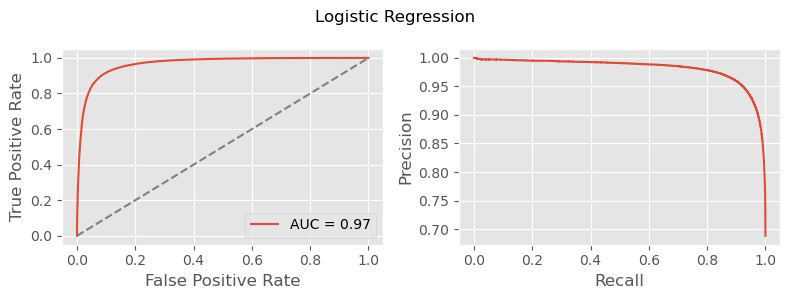

In [14]:
fpr, tpr, _ = roc_curve(y_test, lr_y_pred_score pos_label=lr.classes_[1])
prec, recall, _ = precision_recall_curve(y_test, lr_y_pred_score, pos_label=lr.classes_[1])
auc = roc_auc_score(y_test,lr_ y_pred_score)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc).plot(axs[0])
PrecisionRecallDisplay(precision=prec, recall=recall).plot(axs[1])
# cm = confusion_matrix(y_test, y_pred)
# ConfusionMatrixDisplay(cm).plot()
axs[0].plot((0,1), (0,1), ls='--', c='gray')
fig.suptitle('Logistic Regression')
plt.tight_layout()
plt.show()

#### Follow up
There are a few avenues that I could follow here. 
1) Examine the items that are misclassified and see what commonalities that they have.
2) Examine the coeffients to see what the features with the most predictive power are (guess: restaurant, food, etc.)
3) I have a guess that there is heteroscedasticity in the predictions (i.e. The reviews with fewer words have larger residuals than longer reviews). It would be interesting to explore this.

##### Coefficents

In [66]:
vocab_sorted = sorted(tf.vocabulary_.items())
word_coef_df = pd.DataFrame(dict(vocab_sorted).keys(), columns=['word'])
word_coef_df['lr_coef'] = lr.coef_[0]
word_coef_df['abs_lr_coef'] = np.abs(word_coef_df['lr_coef'])

In [79]:
word_coef_df.sort_values('abs_lr_coef', ascending=False).head(10)

,word,lr_coef,abs_lr_coef
162,food,11.043765,11.043765
326,pizza,9.312101,9.312101
18,appointment,-9.110789,9.110789
373,salon,-9.073784,9.073784
361,restaurant,8.760500,8.760500
264,massage,-7.863493,7.863493
473,waitress,7.622367,7.622367
280,nail,-7.298391,7.298391
471,waiter,7.198308,7.198308
52,brunch,7.079508,7.079508


Most of these make a lot of sense to me and are as expected.

In [77]:
word_coef_df.sort_values('abs_lr_coef', ascending=False).tail(10)

,word,lr_coef,abs_lr_coef
256,loved,-0.024734,0.024734
185,green,-0.015755,0.015755
145,extra,-0.012694,0.012694
78,city,-0.011250,0.011250
478,warm,0.009300,0.009300
134,enjoy,0.009275,0.009275
196,heard,0.005965,0.005965
370,said,0.005658,0.005658
167,friday,-0.005420,0.005420
209,huge,-0.004538,0.004538


Same findings here. These words don't strongly convey restaurant or not-restaurant to me.

##### Heteroscedasticity

In [ ]:
lr_residuals = y_test - lr_y_pred_score[:,1]
X_test_text_length = [len(x.split()) for x in X_test]

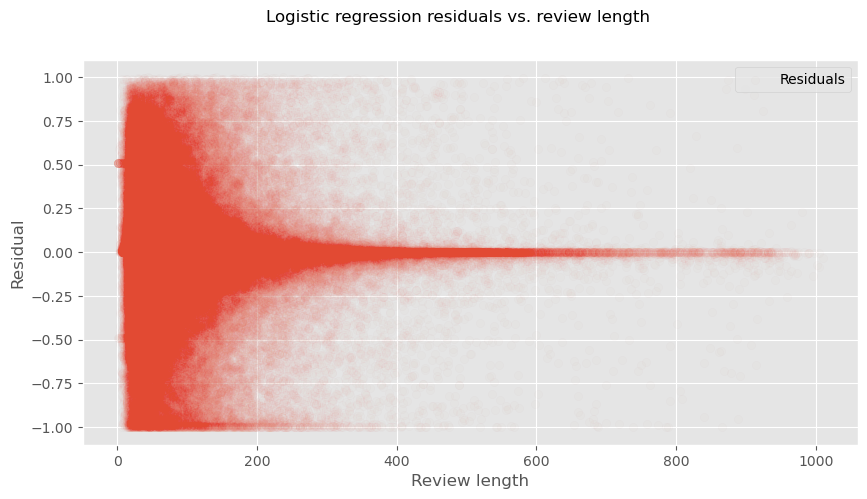

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X_test_text_length, lr_residuals, alpha=0.01, label='Residuals')
ax.set_xlabel('Review length')
ax.set_ylabel('Residual')
fig.suptitle('Logistic regression residuals vs. review length')
ax.legend()
plt.show()

This makes sense. The longer the review, the lower the chance that the model gets it incorrect.

### Random forest classifier

This takes a really long time to train, so I'm going to subsample the data and do some averaging for the metrics.

In [83]:
# I'm selecting a few subsample sets from the training set, given the size of the data and training time.
# Ideally I would do some K-Fold cross-validation here and later hyper-parameter tuning, but for time-constraints
# I decided against it.
# sklearn.model_selection.ShuffleSplit could be a good way to do this as well
num_slices = 5
max_dataset = 100000
indices_dict = dict()
for i in range(num_slices):
    indices_dict[i] = np.random.choice(tfidf.shape[0], size=max_dataset, replace=True)

In [153]:
# Starting with default values
fprs = []
tprs = []
precs = []
recalls = []
aucs = []
rf_y_pred_scores = []

for i in range(num_slices):
    rf = RandomForestClassifier(bootstrap=True, n_jobs=-1, random_state=42)
    rf.fit(tfidf[indices_dict[i]], y_train[indices_dict[i]])
    rf_y_pred_score = rf.predict_proba(tfidf_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, rf_y_pred_score, pos_label=rf.classes_[1])
    prec, recall, _ = precision_recall_curve(y_test, rf_y_pred_score, pos_label=rf.classes_[1])
    auc = roc_auc_score(y_test, rf_y_pred_score)
    fprs.append(fpr)
    tprs.append(tpr)
    precs.append(prec)
    recalls.append(recall)
    aucs.append(auc)
    rf_y_pred_scores.append(rf_y_pred_score)

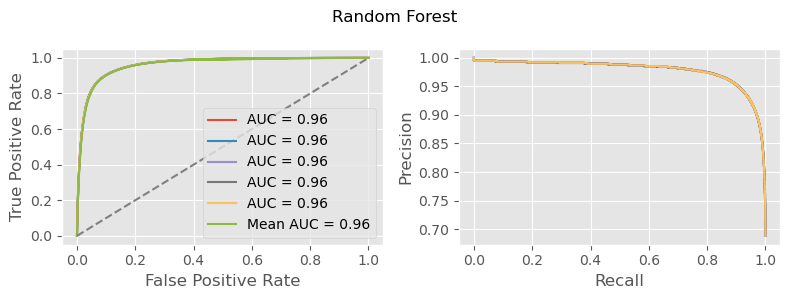

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for i in range(num_slices):
    RocCurveDisplay(fpr=fprs[i], tpr=tprs[i], roc_auc=aucs[i]).plot(axs[0])
    PrecisionRecallDisplay(precision=precs[i], recall=recalls[i]).plot(axs[1])
RocCurveDisplay(fpr=pd.DataFrame(fprs).mean(axis=0).values, 
            tpr=pd.DataFrame(tprs).mean(axis=0).values, 
            roc_auc=np.array(aucs).mean()).plot(axs[0], 
                                                label='Mean AUC = {}'.format(round(np.array(aucs).mean(),
                                                                                  2)))
axs[0].plot((0,1), (0,1), ls='--', c='gray')
fig.suptitle('Random Forest')
plt.tight_layout()
plt.show()

#### Follow up
Similar to the logistic regression above, next steps could be to:
1) Examine the feature importance to see what the features were split on the most times.
2) Take a look at the heteroscedasticity of the residuals vs. the text lenght

##### Feature importance
I'm only looking at the feature importance of the last-trained model for simplicity, noting that this could change slightly depending on which data slice I trainined on.

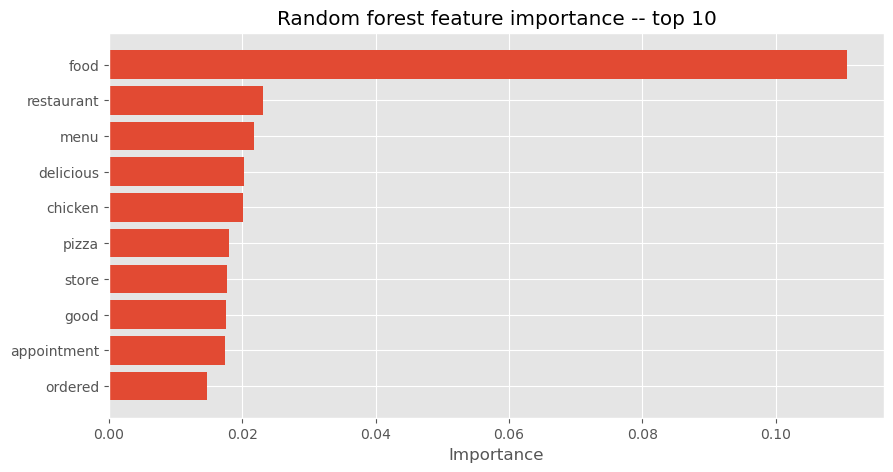

In [155]:
word_coef_df['feature_importance'] = rf.feature_importances_
fig, ax = plt.subplots(figsize=(10,5))
top_features = 10
top_words = word_coef_df.sort_values('feature_importance', ascending=False)[:top_features][::-1]

ax.barh(range(top_features), top_words['feature_importance'], align='center')
ax.set_yticks(range(top_features), top_words['word'])
ax.set_xlabel('Importance')
plt.title('Random forest feature importance -- top {}'.format(top_features))
plt.show()

Seeing these words as the most frequently split on make a lot of sense given that they can obviously be restaurant words. "Appointment" and "store" may be more likely to split highlight non-restaurant tags.

##### Heteroscedasticity

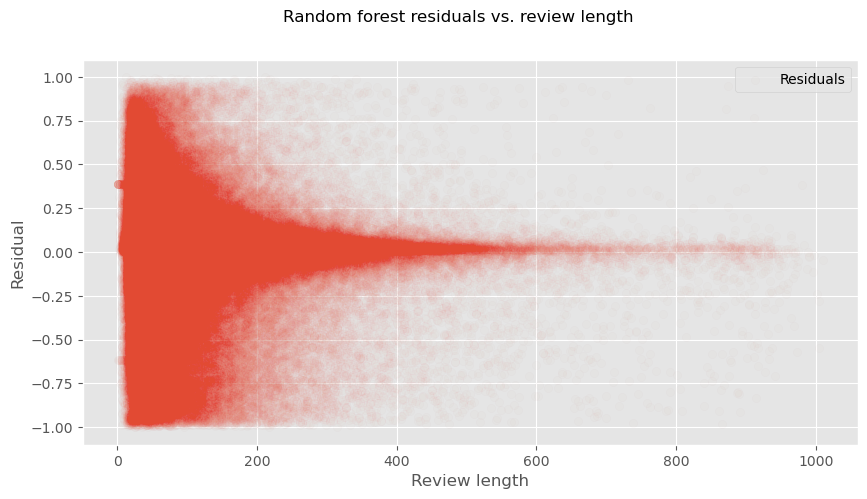

In [161]:
rf_residuals = y_test - np.array(rf_y_pred_scores).mean(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X_test_text_length, rf_residuals, alpha=0.01, label='Residuals')
ax.set_xlabel('Review length')
ax.set_ylabel('Residual')
fig.suptitle('Random forest residuals vs. review length')
ax.legend()
plt.show()

Again, this makes a lot of sense and agrees materially with the logistic regression classifier.

# Sample Texts

In [18]:
test_texts = pd.DataFrame(['best burritos in town close to my house service is excellent',
              'i hate this place its the worst service ive ever experienced i will never go back',
              'i love buying my car parts here',
              'ive been going to this dentist for 5 years and every time ive had a good experience'], columns = ['text'])

sample_tfidf = tf.transform(test_texts['text'])

test_texts['lr_predict'] = lr.predict_proba(sample_tfidf)[:,1]
test_texts['rf_predict'] = rf.predict_proba(sample_tfidf)[:,1]
test_texts

,text,lr_predict,rf_predict
0,best burritos in town close to my house servic...,0.603552,0.55
1,i hate this place its the worst service ive ev...,0.630060,0.36
2,i love buying my car parts here,0.026263,0.11
3,ive been going to this dentist for 5 years and...,0.289412,0.20


# Conclusions
Based on the above, it appears that the LogisticRegression classifier performes better than the RandomForest classifer with an AUC of 0.97 compared to 0.96. However, these are so close, that it could be noise. Both classifiers perform very well over random guessing.

There are many ways that this work could be taken further:
1) Developing a multi-class classifier (not just restaurants)
2) Performing K-fold tests on both models to be sure of the AUC
3) Tuning the hyperparameters
4) Training on a larger dataset (although this is unlikely to impact the model much)
5) Researching into the reviews that the model classified incorrectly
6) Adding other features to the models (zipcode, number of patrons, words in name, review_stars, various other attributes, etc.)
7) Featurzing with n-grams instead of only unigrams
8) Using different word embeddings (Word2Vec)

## Choosing a prediction threshold
The next step in the process could be to select an appropriate threshold for prediction before feeding a user a prompt, taking into account the cost of a FP and FN. For example, if we determine that prompting a user to tag a review as "restaurant" when it is in fact a gas station, may lead to user churn and or dirty data. If we wish to avoid FPs we may choose a higher Precision over Recall for the final deployment.